In [55]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

RESULTS_FILENAME = "good_results.hdf5"

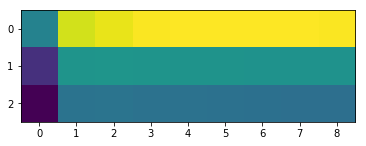

In [60]:
f = h5py.File(RESULTS_FILENAME, "r")
plt.imshow(np.mean(f["weather"]["results"], axis=(0,1)))

In [62]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def decoding_fix_axes(fig_width=10, fig_height=5, hpad=0.1, wpad_edge=0.1, wpad_mid=0.1):
    fig = plt.figure(figsize=(fig_width, fig_height))
    sq_width = (1 - 2*wpad_edge - 2*wpad_mid)/3
    sq_height = sq_width * fig_width/fig_height
    ax1 = fig.add_axes((wpad_edge, hpad, sq_width, sq_height))
    ax2 = fig.add_axes((wpad_edge + sq_width + wpad_mid, hpad, sq_width, sq_height))
    ax3 = fig.add_axes((wpad_edge + 2*sq_width + 2*wpad_mid, hpad, sq_width, sq_height))
    axes = [ax1, ax2, ax3]
    return axes

def plot_delta_r2(ax, results, dset_idx=0, T_idx=0, leftmost_ax=False):
    num_cv_folds = f.attrs["num_cv_folds"]
    dset_names = f.attrs["dset_names"]
    dim_vals = f.attrs["dim_vals"]
    offset_vals = f.attrs["offset_vals"]
    n_dim = len(dim_vals)
    n_offsets = len(offset_vals)
    sem_factor = np.sqrt(1/num_cv_folds + 1/(num_cv_folds-1))
    
    pca_vals = results[dset_idx, :, :, :, 0]
    dca_vals = results[dset_idx, :, :, :, T_idx+1]
    diffs_mean = (dca_vals - pca_vals).mean(axis=0)
    diffs_sem = (dca_vals - pca_vals).std(axis=0)*sem_factor
    
    #diffs_mean /= pca_vals.mean(axis=0)
    #diffs_sem /= pca_vals.mean(axis=0)
    
    #(0, 1) = (dim, offset)

    #scatter and make errorbars
    x_vals = np.concatenate([np.arange(n_dim)+(n_dim + 3)*i for i in range(len(offset_vals))])
    colors = [default_colors[i % n_dim] for i in range(len(x_vals))]
    ax.scatter(x_vals, diffs_mean.T.flatten(), c=colors, s=20)
    ax.errorbar(x_vals, y=diffs_mean.T.flatten(), yerr=diffs_sem.T.flatten(), linestyle="None", c=colors)
    ax.axhline(0, c="black", linestyle="--")

    #set x-ticks
    x_ticks = [n_dim/2 + (n_dim + 3)*i for i in range(len(offset_vals))]
    x_tick_labels = ["$\Delta t$=" + str(offset_vals[i]) for i in range(n_offsets)]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, fontsize=16)
    
    #set xlabel/title
    ax.set_xlabel("time lag [bins]", fontsize=16)
    names = {"hc": "Hippocampus", "m1": "M1/PMd", "s1": "S1"}
    ax.set_title(names[dset_names[dset_idx]], fontsize=18)
    
    if leftmost_ax:
        #set ylabel
        ax.set_ylabel("$\Delta R^2$ (DCA - PCA)", fontsize=16)
        
        #make legend
        for i in range(n_dim):
            ax.scatter(x_vals[i], diffs_mean.T.flatten()[i], c=colors[i], label="$d$="+str(dim_vals[i]), s=20)
        ax.legend(frameon=True, fontsize=10, loc="lower right", ncol=2)
        
        
